In [271]:
import math
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm

from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.operator.crossover import PMXCrossover

from jmetal.operator import BinaryTournamentSelection
from jmetal.util.comparator import MultiComparator
from jmetal.util.ranking import StrengthRanking
from jmetal.util.density_estimator import KNearestNeighborDensityEstimator

from jmetal.util import termination_criterion
from jmetal.util.observer import ProgressBarObserver

In [272]:
class TSP(PermutationProblem):
    def __init__(self, distance_matrix, number_of_cities):
        super(TSP, self).__init__()
        self.distance_matrix = distance_matrix
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = number_of_cities
        self.number_of_objectives = 1
        self.number_of_constraints = 0
    
    def read_from_file(filename):
        if filename is None:
            raise FileNotFoundError('Filename can not be None')
        with open(filename) as file:
            lines = file.readlines()
            data = [line.lstrip() for line in lines if line != ""]
            dimension = re.compile(r'[^\d]+')
            for item in data:
                if item.startswith('DIMENSION'):
                    dimension = int(dimension.sub('', item))
                    break
            c = [-1.0] * (2 * dimension)
            city_coord = []
            for item in data:
                if item[0].isdigit():
                    j, city_X, city_Y = [float(x.strip()) for x in item.split(' ')]
                    c[2 * (int(j) - 1)] = city_X
                    c[2 * (int(j) - 1) + 1] = city_Y
                    city_coord.append([city_X,city_Y])
            city = pd.DataFrame(city_coord)
            matrix = [[-1] * dimension for _ in range(dimension)]
            for k in range(dimension):
                matrix[k][k] = 0
                for j in range(k + 1, dimension):
                    dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                    dist = round(dist)
                    matrix[k][j] = dist
                    matrix[j][k] = dist
            return matrix, dimension, city
    
    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        for i in range(self.number_of_variables - 1):
            x = solution.variables[i]
            y = solution.variables[i + 1]
            fitness += self.distance_matrix[x][y]
        first_city, last_city = solution.variables[0], solution.variables[-1]
        fitness += self.distance_matrix[first_city][last_city]
        solution.objectives[0] = fitness
        fitness_log.append(fitness)
        return solution
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution

    @property
    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'Symmetric TSP'

In [273]:
def print_solution(my_algo, pop_evolved, log, params):
    algorithm_name = my_algo.get_name()
    solution_x = pop_evolved.variables
    fitness = pop_evolved.objectives[0]
    n_evals = my_algo.evaluations
    duration = my_algo.total_computing_time
    print('-' *60)
    print("Function: %s" % locality)
    print("Problem dimension: %d" % len(solution_x))
    print('-' *60)
    print("Algorithm: %s" % algorithm_name)
    print("Parameters:")
    for p in params:
        print("\t%s: " % p ,params[p] )
    print('-' *60)
    print("Fitness: %d" % fitness)
    print("Solution: ")
    print(solution_x)
    print('-' *60)
    print("Nb of functions evaluations: %d" % n_evals)
    print("Stopping criterion: after %d evals" % maxevals)
    print("computational time: %.3f seconds" % duration)

    plt.plot(log[::1000])
    plt.xlabel("evaluations (x1000)")
    plt.ylabel("fitness")
    plt.show()

In [274]:
tsp =TSP
locality = 'Djibouti'
dist_matrix, nb_cities, cities_coord = tsp.read_from_file('./dj38.tsp')
myproblem = TSP(dist_matrix, nb_cities)

In [281]:
maxevals = 200000

popsize = 10000
offspring = 10000
mut_prob = 0.001
cross_prob = 0.3

select = BinaryTournamentSelection(
                        MultiComparator([StrengthRanking.get_comparator(),
                                         KNearestNeighborDensityEstimator.get_comparator()]
                                       ))

termin = termination_criterion.StoppingByEvaluations(max_evaluations=maxevals)

algorithm = GeneticAlgorithm(
    problem=myproblem,
    population_size=popsize,
    offspring_population_size=offspring,
    mutation=PermutationSwapMutation(mut_prob),
    crossover=PMXCrossover(cross_prob),
    selection=select,
    termination_criterion=termin
)

params = {'population':popsize, 
          'offspring':offspring, 
          'mutation probability': mut_prob, 
          'crossover probability': cross_prob,
         }


Progress: 100%|##############################################################| 200000/200000 [00:47<00:00, 4202.19it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.05
	crossover probability:  0.9
------------------------------------------------------------
Fitness: 9648
Solution: 
[19, 22, 24, 25, 28, 29, 31, 34, 36, 37, 35, 30, 1, 0, 9, 13, 20, 32, 33, 26, 27, 23, 18, 17, 16, 15, 11, 10, 8, 7, 6, 5, 4, 2, 3, 12, 14, 21]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 47.710 seconds


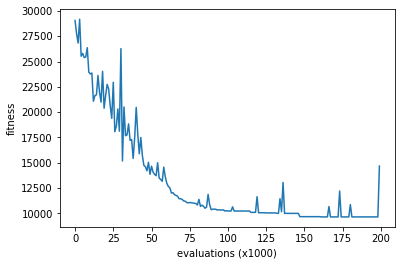

In [270]:

# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [00:51<00:00, 3866.90it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.05
	crossover probability:  0.9
------------------------------------------------------------
Fitness: 14859
Solution: 
[11, 14, 15, 10, 7, 12, 8, 2, 18, 23, 25, 1, 6, 16, 17, 4, 3, 26, 27, 19, 21, 24, 5, 0, 9, 13, 20, 29, 31, 28, 36, 34, 22, 37, 33, 32, 30, 35]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 52.863 seconds


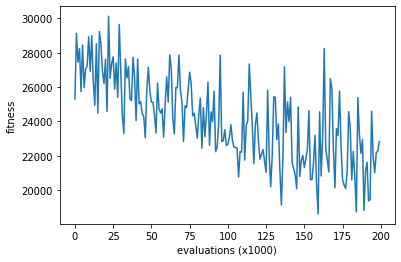

In [267]:

# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [00:42<00:00, 4662.07it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.01
	crossover probability:  0.6
------------------------------------------------------------
Fitness: 10386
Solution: 
[9, 15, 18, 17, 16, 11, 5, 3, 1, 0, 29, 34, 36, 37, 32, 26, 10, 4, 2, 6, 7, 8, 12, 14, 24, 25, 22, 19, 21, 23, 27, 30, 35, 33, 31, 28, 20, 13]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 43.018 seconds


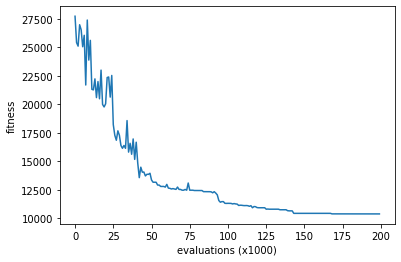

In [276]:
# run algorithm and print solution
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [00:43<00:00, 4632.97it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.01
	crossover probability:  0.6
------------------------------------------------------------
Fitness: 16128
Solution: 
[19, 25, 34, 35, 32, 36, 28, 16, 6, 17, 26, 33, 37, 29, 31, 20, 9, 13, 5, 14, 30, 22, 23, 7, 27, 15, 18, 8, 10, 4, 2, 3, 1, 0, 24, 12, 11, 21]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 44.285 seconds


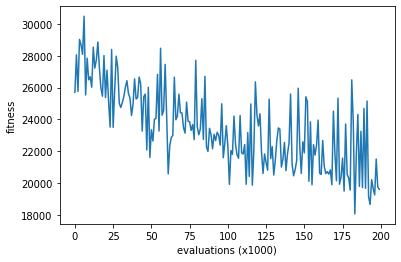

In [278]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [00:34<00:00, 5850.78it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  1000
	offspring:  1000
	mutation probability:  0.001
	crossover probability:  0.3
------------------------------------------------------------
Fitness: 10962
Solution: 
[16, 14, 21, 24, 25, 22, 12, 4, 2, 1, 0, 20, 13, 9, 3, 18, 11, 10, 17, 15, 7, 8, 5, 6, 19, 28, 29, 31, 37, 35, 32, 33, 30, 26, 27, 36, 34, 23]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 34.300 seconds


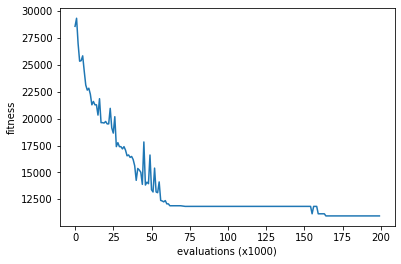

In [280]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)

Progress: 100%|##############################################################| 200000/200000 [00:35<00:00, 5644.00it/s]


------------------------------------------------------------
Function: Djibouti
Problem dimension: 38
------------------------------------------------------------
Algorithm: Genetic algorithm
Parameters:
	population:  10000
	offspring:  10000
	mutation probability:  0.001
	crossover probability:  0.3
------------------------------------------------------------
Fitness: 16472
Solution: 
[10, 11, 27, 29, 20, 9, 0, 3, 14, 23, 26, 1, 7, 36, 33, 35, 30, 32, 34, 37, 12, 18, 17, 6, 4, 2, 31, 28, 13, 15, 24, 25, 22, 19, 21, 8, 16, 5]
------------------------------------------------------------
Nb of functions evaluations: 200000
Stopping criterion: after 200000 evals
computational time: 36.571 seconds


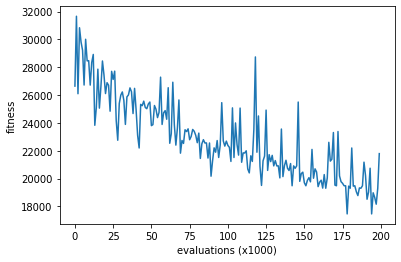

In [282]:
fitness_log = []

progress_bar = ProgressBarObserver(max=maxevals)
algorithm.observable.register(progress_bar)

algorithm.run()
result = algorithm.get_result()
print_solution(algorithm, result, fitness_log, params)